In [85]:
import pandas as pd

returns = pd.read_pickle('Data/long_short_returns.pkl')
hhi = pd.read_pickle('Data/HHI.pkl')
etf_share = pd.read_pickle('Data/etf_share.pkl')
hhi_series = hhi.pivot(index='date', columns='industry', values='HHI')
returns = returns.squeeze()
mktcap = hhi.pivot(index='date', columns='industry', values='Industry_MktCap')
pb_short = pd.read_pickle("Data/pb_short.pkl")
price_short = pd.read_pickle("Data/price_short.pkl")
bv_short = pd.read_pickle("Data/bv_short.pkl")
div_short = pd.read_pickle("Data/div_short.pkl")

In [20]:
weights = mktcap.div(mktcap.sum(axis=1), axis=0)
vw_hhi = (hhi_series * weights).sum(axis=1)
vw_hhi.name = 'vw_hhi'
vw_hhi = vw_hhi.dropna()
vw_hhi.head()

date
1960-01-01    0.096311
1960-02-01    0.096763
1960-03-01    0.098573
1960-04-01    0.101176
1960-05-01    0.102688
Name: vw_hhi, dtype: float64

In [22]:
print(hhi_series.index.equals(weights.index))  # Should be True
print(hhi_series.columns.equals(weights.columns))  # Should be True


True
True


In [57]:
df = pd.concat([returns, vw_hhi, etf_share], axis=1).dropna()
df.columns = ['returns', 'vw_hhi', 'etf_share']

<Axes: title={'center': 'Rolling Correlation (5 years)'}>

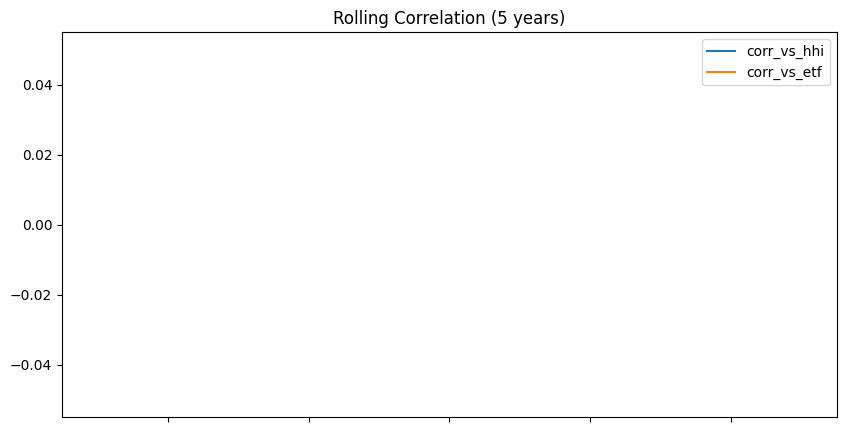

In [56]:
df['corr_vs_hhi'] = df['returns'].rolling(60).corr(df['vw_hhi'])
df['corr_vs_etf'] = df['returns'].rolling(60).corr(df['etf_share'])

df[['corr_vs_hhi', 'corr_vs_etf']].plot(title='Rolling Correlation (5 years)', figsize=(10,5))


In [62]:
import statsmodels.api as sm

X = df[['vw_hhi', 'etf_share']]
X = sm.add_constant(X)
y = df['returns']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.600
Date:                Wed, 18 Jun 2025   Prob (F-statistic):              0.204
Time:                        17:43:10   Log-Likelihood:                 650.29
No. Observations:                 306   AIC:                            -1295.
Df Residuals:                     303   BIC:                            -1283.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.008      0.744      0.4

In [63]:
df['post2008'] = (df.index >= '2008-09-01').astype(int)

# Interaction terms
df['hhi_post'] = df['vw_hhi'] * df['post2008']
df['etf_post'] = df['etf_share'] * df['post2008']

X = df[['vw_hhi', 'etf_share', 'post2008', 'hhi_post', 'etf_post']]
X = sm.add_constant(X)

model = sm.OLS(df['returns'], X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.6536
Date:                Wed, 18 Jun 2025   Prob (F-statistic):              0.659
Time:                        17:43:59   Log-Likelihood:                 650.34
No. Observations:                 306   AIC:                            -1289.
Df Residuals:                     300   BIC:                            -1266.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.010      0.590      0.5

In [67]:
from statsmodels.tsa.api import VAR

var_df = df[['returns', 'vw_hhi', 'etf_share']]
var_model = VAR(var_df).fit(maxlags=4, ic='aic')
var_model.summary()

Y = df['returns']
X = df[['vw_hhi', 'etf_share']]
X_sm = sm.add_constant(X)

model = sm.OLS(Y, X_sm)
results = model.fit(cov_type="HC3")
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.015
Date:                Fri, 20 Jun 2025   Prob (F-statistic):              0.135
Time:                        10:56:50   Log-Likelihood:                 650.29
No. Observations:                 306   AIC:                            -1295.
Df Residuals:                     303   BIC:                            -1283.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.009      0.667      0.5

In [78]:
#Preparing data
pb_short_cleaned = []
for entry in pb_short:
    date = entry['date']
    pb_series = entry['pb_short']
    if isinstance(pb_series, pd.Series):
        avg_pb = pb_series.mean()
    else:
        avg_pb = pb_series  # fallback in case it's already scalar
    pb_short_cleaned.append({'date': date, 'pb_short': avg_pb})


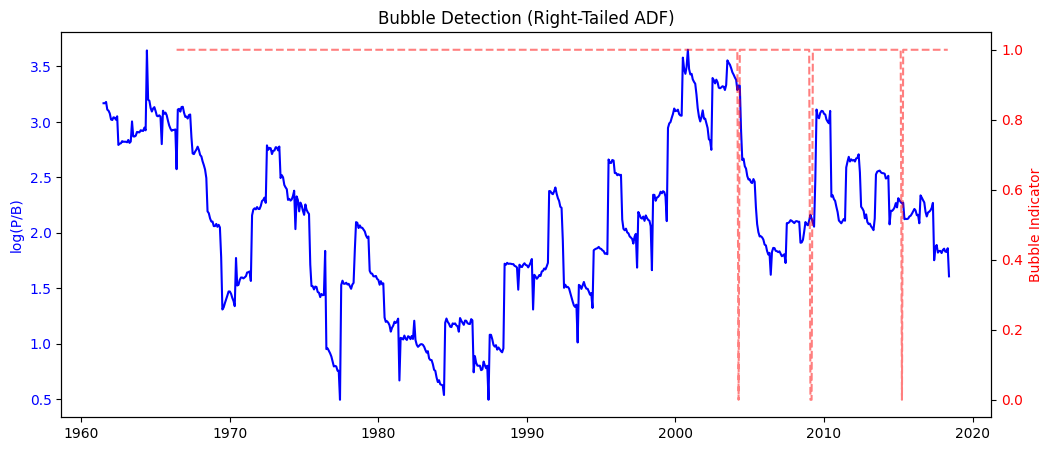

            adf_stat  crit_value_1pct  bubble_flag
date                                              
1966-06-01 -2.313839        -3.548494         True
1966-07-01 -2.857806        -3.548494         True
1966-08-01 -3.034974        -3.548494         True
1966-09-01 -3.020587        -3.548494         True
1966-10-01 -2.954451        -3.548494         True
...              ...              ...          ...
2018-01-01 -1.581578        -3.548494         True
2018-02-01 -1.593018        -3.548494         True
2018-03-01 -1.529575        -3.548494         True
2018-04-01 -1.399145        -3.548494         True
2018-05-01 -1.302740        -3.548494         True

[624 rows x 3 columns]


In [138]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt

# === INPUT: time series of valuation metric, e.g., log(P/B) of growth stocks ===
# This should be a pd.Series with datetime index
# Example: log_pb = np.log(growth_portfolio_data['P/B'])

def rolling_adf_test(series, min_window=24):
    """
    Runs rolling ADF tests on a time series.
    Returns the ADF statistic and critical value at each step.
    """
    adf_stats = []
    crit_vals = []
    dates = []

    for start in range(0, len(series) - min_window):
        window = series.iloc[start:start + min_window]
        if window.isnull().any():
            adf_stats.append(np.nan)
            crit_vals.append(np.nan)
            dates.append(series.index[start + min_window - 1])
            continue
        
        adf_result = ts.adfuller(window, maxlag=1, regression='c', autolag=None)
        adf_stats.append(adf_result[0])
        crit_vals.append(adf_result[4]['1%'])  # right-tailed rejection at 1%
        dates.append(series.index[start + min_window - 1])

    results = pd.DataFrame({
        'date': dates,
        'adf_stat': adf_stats,
        'crit_value_1pct': crit_vals
    }).set_index('date')

    results['bubble_flag'] = results['adf_stat'] > results['crit_value_1pct']
    return results


pb_short_df = pd.DataFrame(pb_short_cleaned)
pb_short_df.set_index('date', inplace=True)
pb_short_df.index = pb_short_df.index.to_timestamp()

log_pb = np.log(pb_short_df["pb_short"]).dropna()



bubble_results = rolling_adf_test(log_pb, min_window=60)

# === Plot ===
def plot_bubble_detection(bubble_results, series, title='Bubble Detection (Right-Tailed ADF)'):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    ax1.plot(series.index, series, label='Valuation Ratio', color='blue')
    ax1.set_ylabel('log(P/B)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Add bubble regions
    ax2 = ax1.twinx()
    ax2.plot(bubble_results.index, bubble_results['bubble_flag'].astype(int), 
             color='red', label='Bubble Indicator', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Bubble Indicator', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    plt.title(title)
    plt.show()

# === To run ===
plot_bubble_detection(bubble_results, log_pb)
print(bubble_results)


In [145]:
#Fundamentals vs Market Valuation Decomposition
log_price_short = np.log(price_short['avg_value'])
log_price_short.name = 'log_price_short'

log_bv_short = np.log(bv_short['avg_value'])
log_bv_short.name = 'log_bv_short'

#div_short = div_short['avg_value']
div_short.name = 'div_short'

df = pd.concat([log_price_short, log_bv_short, div_short], axis=1, join="inner")
Y = df['log_price_short']
X = df[['log_bv_short', 'div_short']]
X_sm = sm.add_constant(X)

model = sm.OLS(Y, X_sm)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_price_short   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2779.
Date:                Fri, 20 Jun 2025   Prob (F-statistic):           3.54e-55
Time:                        14:38:50   Log-Likelihood:                 25.641
No. Observations:                  57   AIC:                            -45.28
Df Residuals:                      54   BIC:                            -39.15
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.5104      0.333     10.557   

<Axes: title={'center': 'Non-fundamental Component (Bubble Measure)'}, xlabel='date'>

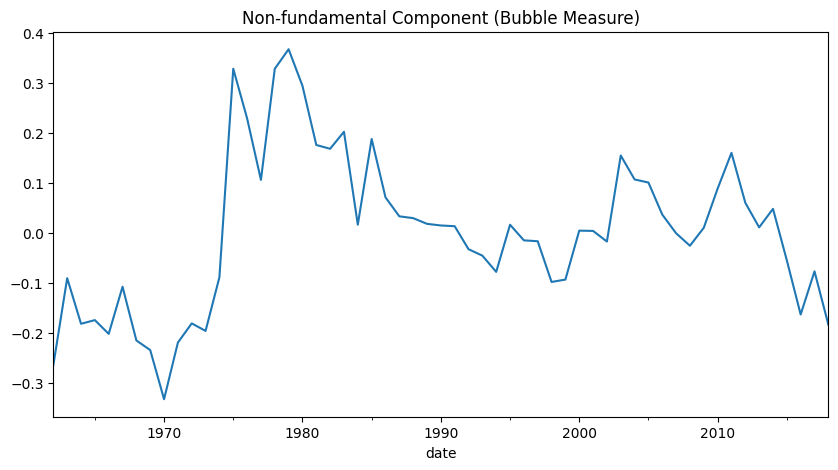

In [123]:
df['residual'] = results.resid
df['residual'].plot(title="Non-fundamental Component (Bubble Measure)", figsize=(10, 5))


In [124]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['residual'].dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF Statistic: -2.7488230825911453
p-value: 0.06596402404717264


In [125]:
from statsmodels.tsa.stattools import coint
score, pvalue, _ = coint(df['log_price_short'], df['log_bv_short'])
print(f"Cointegration p-value: {pvalue}")

Cointegration p-value: 0.1676634986669277


In [136]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
data = df[['log_price_short','log_bv_short']]
jres = coint_johansen(data, det_order=-1, k_ar_diff=1)

# Results:
print("Eigenvalues:", jres.eig)
print("Trace statistic:", jres.lr1)         # Trace test statistics
print("Critical values (90%, 95%, 99%):", jres.cvt)  # Critical values for trace test
print("Max-eigen statistic:", jres.lr2)     # Max eigenvalue statistics
print("Critical values for max-eigen:", jres.cvm)

Eigenvalues: [0.10886415 0.01593085]
Trace statistic: [7.22246297 0.883251  ]
Critical values (90%, 95%, 99%): [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]
Max-eigen statistic: [6.33921197 0.883251  ]
Critical values for max-eigen: [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]]


In [137]:
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import VECM

# Your dataframe with columns, e.g. 'log_price_short', 'log_bv_short', 'div_short'
# Make sure it is a pandas DataFrame with no missing values and proper datetime index
#print(data.tail())

vecm = VECM(data, k_ar_diff=1, coint_rank=1, deterministic='ci')  # 'ci' means constant in cointegration relation
vecm_res = vecm.fit()
print(vecm_res.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation log_price_short
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.log_price_short     0.1689      0.331      0.510      0.610      -0.480       0.818
L1.log_bv_short       -0.2560      0.320     -0.800      0.424      -0.883       0.371
Det. terms outside the coint. relation & lagged endog. parameters for equation log_bv_short
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.log_price_short     0.3127      0.360      0.868      0.385      -0.394       1.019
L1.log_bv_short       -0.1693      0.348     -0.486      0.627      -0.852       0.513
          Loading coefficients (alpha) for equation log_price_short           
                 coef    std err      

Results of tests for valuation bubbles in the short positions:
Johannsens Cointegration Test suggests cointegration -> long-term equilibrium for both time-series
Engle-Granger Test suggests a bubble (only with small significance p ~ 0.066)

Prices are weakly tied to fundamentals, but not statistically robust enough to rule out a potential bubble:
- Cointegration cannot be confirmed -> potential bubble risk
- System is not explosive -> possibly rational bubble or mean-reverting with weak force

In [158]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Assuming `df` is your DataFrame and contains `log_price_short`
# Convert to numpy array and drop NaNs
y = df['log_price_short'].dropna().values
y_scaled = (y - y.mean()) / y.std()

"""X = sm.add_constant(df[['log_bv_short']].dropna())
model = MarkovRegression(y_scaled, k_regimes=2, exog=X, trend='c', switching_variance=True)"""


# Fit a 2-regime Markov switching autoregressive model (AR(1) with regime switching)
model = MarkovRegression(y_scaled, k_regimes=2, trend='c', switching_variance=True)
res = model.fit()

# Print summary
print(res.summary())


                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                   57
Model:               MarkovRegression   Log Likelihood                 -24.388
Date:                Fri, 20 Jun 2025   AIC                             60.776
Time:                        15:03:07   BIC                             73.034
Sample:                             0   HQIC                            65.540
                                 - 57                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7156      0.096     -7.440      0.000      -0.904      -0.527
sigma2         0.2917      0.078      3.745      0.0

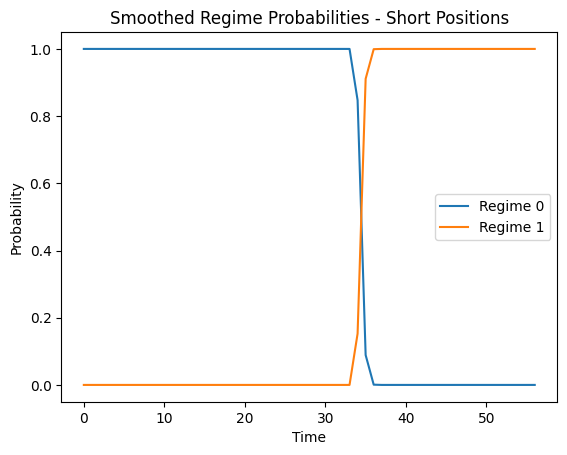

In [159]:
import matplotlib.pyplot as plt

probs = res.smoothed_marginal_probabilities

# If DataFrame
if hasattr(probs, 'iloc'):
    plt.plot(probs.iloc[:, 0], label='Regime 0')
    plt.plot(probs.iloc[:, 1], label='Regime 1')
else:  # If numpy array
    plt.plot(probs[:, 0], label='Regime 0')
    plt.plot(probs[:, 1], label='Regime 1')

plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Smoothed Regime Probabilities - Short Positions')
plt.legend()
plt.show()

